In [2]:
!nvidia-smi

Sat May 16 15:47:48 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.40.04    Driver Version: 418.40.04    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  Off  | 00000000:1A:00.0 Off |                    0 |
| N/A   35C    P0    36W / 250W |  15820MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   34C    P0    36W / 250W |      0MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [1]:
import os
import sys
from importlib import reload

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

import torch
from torch.utils import data as D
# mixed precision
from apex import amp

# Local imports
sys.path.append('../src')
import dataset
import trainer
import models
import utils
import preprocessing
import mix
import transforms

# Transformers
import transformers
from transformers import XLMRobertaModel, XLMRobertaTokenizer, XLMRobertaConfig
from transformers import AdamW, get_linear_schedule_with_warmup, get_constant_schedule

# Prediction analysis
from sklearn.metrics import roc_auc_score, accuracy_score
from scipy.special import softmax
from sklearn.calibration import calibration_curve

# Setup device
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Seed 
utils.seed_everything()

print('use', device)

[nltk_data] Downloading package punkt to
[nltk_data]     /gpfs/hpc/home/papkov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
use cuda


## Datasets

In [2]:
reload(dataset)

<module 'dataset' from '../src/dataset.py'>

In [3]:
debug = False
use_features = True
feature_slice = slice(0,3072)

In [4]:
%%time
if debug:
    valid = dataset.Dataset('../input/validatio_debug_32.npz')
else:
    valid = dataset.Dataset('../input/validation.npz', use_features=use_features, feature_slice=feature_slice)
#     valid = dataset.Dataset('../input/jigsaw_miltilingual_valid_translated.npz', use_features=use_features)
valid.x.shape, valid.y.shape

CPU times: user 0 ns, sys: 162 ms, total: 162 ms
Wall time: 667 ms


((8000, 3072), (8000,))

In [5]:
%%time
if debug:
    test = dataset.Dataset('../input/test_debug_32.npz')
else:
    test = dataset.Dataset('../input/test.npz', use_features=use_features, feature_slice=feature_slice)
test.x.shape, test.y.shape

CPU times: user 0 ns, sys: 886 ms, total: 886 ms
Wall time: 3.92 s


((63812, 3072), (63812,))

In [6]:
%%time
if debug:
    train = dataset.Dataset('../input/jigsaw-toxic-comment-trai_debug_32.npz')
else:
    train = dataset.Dataset('../input/jigsaw-toxic-comment-train.npz', use_features=use_features, feature_slice=feature_slice)
train.x.shape, train.y.shape

CPU times: user 239 ms, sys: 2.62 s, total: 2.86 s
Wall time: 12.4 s


((223549, 3072), (223549,))

In [8]:
np.save('../input/jigsaw_roberta_features/jigsaw-toxic-comment-train_y.npy', train.y)
np.save('../input/jigsaw_roberta_features/validation_y.npy', valid.y)
np.save('../input/jigsaw_roberta_features/test_y.npy', test.y)

In [121]:
%%time
if debug:
    train_aux = dataset.Dataset('../input/jigsaw-toxic-comment-trai_debug_32.npz')
else:
    train_aux = dataset.Dataset('../input/jigsaw-unintended-bias-train.npz', use_features=use_features)
train_aux.x.shape, train_aux.y.shape

CPU times: user 14 s, sys: 28.2 s, total: 42.2 s
Wall time: 1min 43s


((1902194, 3072), (1902194,))

In [9]:
def weighted_sampler(y):
    labels, counts = np.unique(y, return_counts=True)
    weights = counts[::-1] / counts.sum()
    weights = np.array([weights[i] for i in y])
    return torch.utils.data.sampler.WeightedRandomSampler(weights, int(counts.min() * 2))

In [11]:
sampler = weighted_sampler(train.y)

In [12]:
sampler.weights

tensor([0.0957, 0.0957, 0.0957,  ..., 0.0957, 0.9043, 0.0957],
       dtype=torch.float64)

In [310]:
train = torch.utils.data.ConcatDataset([train, valid])
train_y = np.concatenate([d.y for d in train.datasets])
sampler = weighted_sampler(train_y)
len(sampler)

45228

## Model

In [8]:
reload(models)
reload(mix)

<module 'mix' from '../src/mix.py'>

In [7]:
backbone_name = 'xlm-roberta-large'
# backbone = XLMRobertaModel(XLMRobertaConfig.from_pretrained(backbone_name))
backbone = XLMRobertaModel.from_pretrained(backbone_name, output_hidden_states=False, num_labels=1)

In [24]:
# to reload the module and not overload gpu
del model

In [7]:


# model = models.Model(backbone, mix=False, dropout=0.55)
model = models.SimplePoolingHead(mix=mix.Mixup(), dropout=0.5)
# model = models.TransformersPoolingHead(mix=mix.Mixup(), dropout=0.5, relu=True)
# model = models.CustomPoolingHead(mix=mix.Cutmix(continuous=False), dropout=0.5)
# model = models.CustomPoolingHead(in_features=3072, mix=mix.Mixup(), dropout=0.5)
model

SimplePoolingHead(
  (head): Linear(in_features=3072, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

## Feature extraction

In [8]:
reload(preprocessing)

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


[nltk_data] Downloading package punkt to
[nltk_data]     /gpfs/hpc/home/papkov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<module 'preprocessing' from '../src/preprocessing.py'>

In [9]:
preprocessing.extract_roberta_features_to_file('../input/validation.npz', backbone=backbone, device=device)

feature extraction: 100%|##########| 63/63 [04:13<00:00,  4.02s/it]


In [145]:
preprocessing.extract_roberta_features_to_file('../input/jigsaw_miltilingual_valid_translated.npz', backbone=backbone, device=device)

feature extraction: 100%|##########| 63/63 [04:14<00:00,  4.03s/it]


In [10]:
preprocessing.extract_roberta_features_to_file('../input/test.npz', backbone=backbone, device=device)

feature extraction: 100%|##########| 499/499 [34:04<00:00,  4.10s/it]


In [9]:
preprocessing.extract_roberta_features_to_file('../input/jigsaw_miltilingual_test_translated.npz', backbone=backbone, device=device)

feature extraction: 100%|##########| 63/63 [04:13<00:00,  4.02s/it]


In [11]:
preprocessing.extract_roberta_features_to_file('../input/jigsaw-toxic-comment-train.npz', backbone=backbone, device=device, batch_size=128)

feature extraction: 100%|##########| 1747/1747 [1:58:03<00:00,  4.05s/it]


In [113]:
preprocessing.extract_roberta_features_to_file('../input/jigsaw-unintended-bias-train.npz', backbone=backbone, device=device, batch_size=128)

feature extraction:  21%|##        | 3065/14861 [3:26:57<13:17:12,  4.05s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

feature extraction: 100%|##########| 14861/14861 [16:47:01<00:00,  4.07s/it]  


## Data loaders

In [8]:
batch_size = 64
num_workers = 8

loader_train = D.DataLoader(train, 
                            sampler=train.weighted_sampler(), 
#                             sampler=sampler, 
#                             shuffle=True,
                            batch_size=batch_size, num_workers=num_workers)
loader_valid = D.DataLoader(valid, 
                            batch_size=batch_size, num_workers=num_workers)
loader_test = D.DataLoader(test, 
                           batch_size=batch_size, num_workers=num_workers)

In [9]:
len(loader_train), len(loader_valid), len(loader_test)

(669, 125, 998)

## Trainer

In [10]:
reload(trainer)

<module 'trainer' from '../src/trainer.py'>

In [11]:
# we may optimize only head (with encoder pretrained)
# optimizer = AdamW(model.head.parameters(), lr=1e-4)
optimizer = AdamW(model.parameters(), lr=1e-4)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 4, T_mult=2, eta_min=0, last_epoch=-1)
# criterion = trainer.FocalLoss(gamma=2)
# criterion = trainer.DenseCrossEntropy(label_smoothing=0.1)
# scheduler = get_linear_schedule_with_warmup(optimizer, 5, 5)

trnr = trainer.Trainer('simple', model, 
                       loader_train, loader_valid, loader_test,
                       epochs=20,
                       monitor='val_loss',
                       optimizer=optimizer,
                       opt_level='O1',
#                        criterion=criterion,
#                        scheduler=scheduler,
                      )

Use automatic mixed precision at opt_level=O1
Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


## Training

In [12]:
trnr.fit()

ep. 0000 (lr 1.00e-04):   2%|2         | 15/669 [00:00<03:30,  3.10it/s, loss=0.761, acc=0.505]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


ep. 0000 (lr 1.00e-04): 100%|##########| 669/669 [00:05<00:00, 121.52it/s, loss=0.61, acc=0.682] 
/gpfs/hpc/home/papkov/.conda/envs/peenv36/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:113: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
valid: 100%|##########| 125/125 [00:00<00:00, 323.47it/s]


Epoch 0 complete. loss=0.5315, val_loss=0.6072, val_acc=0.6905, val_auc=0.8261
Saved model to ../checkpoints//simple_last.pth


valid: 100%|##########| 125/125 [00:00<00:00, 281.41it/s]

Epoch 1 complete. loss=0.4529, val_loss=0.4931, val_acc=0.8300, val_auc=0.8634
Saved model to ../checkpoints//simple.pth



valid: 100%|##########| 125/125 [00:00<00:00, 252.33it/s]


Epoch 2 complete. loss=0.2879, val_loss=0.4436, val_acc=0.8532, val_auc=0.8753
Saved model to ../checkpoints//simple.pth


valid: 100%|##########| 125/125 [00:00<00:00, 268.79it/s]

Epoch 3 complete. loss=0.3663, val_loss=0.4149, val_acc=0.8656, val_auc=0.8862
Saved model to ../checkpoints//simple.pth



valid: 100%|##########| 125/125 [00:00<00:00, 262.07it/s]

Epoch 4 complete. loss=0.2656, val_loss=0.3834, val_acc=0.8746, val_auc=0.8900
Saved model to ../checkpoints//simple.pth



ep. 0005 (lr 8.54e-05): 100%|##########| 669/669 [00:13<00:00, 50.41it/s, loss=0.452, acc=0.825]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0



valid: 100%|##########| 125/125 [00:00<00:00, 265.45it/s]

Epoch 5 complete. loss=0.3956, val_loss=0.3441, val_acc=0.8804, val_auc=0.8915
Saved model to ../checkpoints//simple.pth



ep. 0006 (lr 7.94e-05): 100%|##########| 669/669 [00:13<00:00, 50.68it/s, loss=0.447, acc=0.831]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0



valid: 100%|##########| 125/125 [00:00<00:00, 214.42it/s]

Epoch 6 complete. loss=0.6938, val_loss=0.3374, val_acc=0.8804, val_auc=0.8935
Saved model to ../checkpoints//simple.pth



valid: 100%|##########| 125/125 [00:00<00:00, 260.88it/s]

Epoch 7 complete. loss=0.4939, val_loss=0.3163, val_acc=0.8800, val_auc=0.8936
Saved model to ../checkpoints//simple.pth



valid: 100%|##########| 125/125 [00:00<00:00, 252.57it/s]


Epoch 8 complete. loss=0.4492, val_loss=0.3190, val_acc=0.8820, val_auc=0.8954
Saved model to ../checkpoints//simple_last.pth


valid: 100%|##########| 125/125 [00:00<00:00, 250.12it/s]


Epoch 9 complete. loss=0.4936, val_loss=0.3178, val_acc=0.8805, val_auc=0.8949
Saved model to ../checkpoints//simple_last.pth


valid: 100%|##########| 125/125 [00:00<00:00, 257.16it/s]

Epoch 10 complete. loss=0.2663, val_loss=0.3196, val_acc=0.8831, val_auc=0.8985
Saved model to ../checkpoints//simple_last.pth



valid: 100%|##########| 125/125 [00:00<00:00, 236.71it/s]

Epoch 11 complete. loss=0.4614, val_loss=0.3085, val_acc=0.8840, val_auc=0.8974
Saved model to ../checkpoints//simple.pth



ep. 0012 (lr 3.45e-05): 100%|##########| 669/669 [00:13<00:00, 48.56it/s, loss=0.432, acc=0.833]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0



valid: 100%|##########| 125/125 [00:00<00:00, 265.71it/s]

Epoch 12 complete. loss=0.3723, val_loss=0.3125, val_acc=0.8821, val_auc=0.8974
Saved model to ../checkpoints//simple_last.pth



valid: 100%|##########| 125/125 [00:00<00:00, 259.89it/s]

Epoch 13 complete. loss=0.2774, val_loss=0.3155, val_acc=0.8835, val_auc=0.8992
Saved model to ../checkpoints//simple_last.pth



valid: 100%|##########| 125/125 [00:00<00:00, 255.81it/s]

Epoch 14 complete. loss=0.5011, val_loss=0.3119, val_acc=0.8826, val_auc=0.8991
Saved model to ../checkpoints//simple_last.pth



ep. 0015 (lr 1.46e-05): 100%|##########| 669/669 [00:13<00:00, 47.83it/s, loss=0.429, acc=0.839]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0



valid: 100%|##########| 125/125 [00:00<00:00, 260.70it/s]

Epoch 15 complete. loss=0.5121, val_loss=0.3044, val_acc=0.8841, val_auc=0.8984
Saved model to ../checkpoints//simple.pth



valid: 100%|##########| 125/125 [00:00<00:00, 232.27it/s]

Epoch 16 complete. loss=0.5833, val_loss=0.3085, val_acc=0.8834, val_auc=0.8987
Saved model to ../checkpoints//simple_last.pth



valid: 100%|##########| 125/125 [00:00<00:00, 276.21it/s]

Epoch 17 complete. loss=0.3380, val_loss=0.3085, val_acc=0.8831, val_auc=0.8992
Saved model to ../checkpoints//simple_last.pth



valid: 100%|##########| 125/125 [00:00<00:00, 267.12it/s]

Epoch 18 complete. loss=0.3478, val_loss=0.3090, val_acc=0.8832, val_auc=0.8995
Saved model to ../checkpoints//simple_last.pth



ep. 0019 (lr 6.16e-07):   1%|1         | 9/669 [00:00<00:21, 30.34it/s, loss=0.434, acc=0.838]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


valid: 100%|##########| 125/125 [00:00<00:00, 266.31it/s]

Epoch 19 complete. loss=0.3339, val_loss=0.3083, val_acc=0.8835, val_auc=0.8995
Saved model to ../checkpoints//simple_last.pth


## Prediction

In [21]:
trnr.load_checkpoint()

Load state in automatic mixed precision mode at opt_level=O1
Loaded model from ../checkpoints//custom_head_bn_bias=False_O1.pth
epoch 19, loss: 0.4936val_loss: 0.2795val_acc: 0.8756val_auc: 0.9041


In [22]:
pred, loss, acc, auc = trnr.validate()

valid: 100%|##########| 125/125 [00:00<00:00, 181.50it/s]


In [294]:
smpred = softmax(pred / 1, 1)[:,1]
smpred[:5]

array([0.11696827, 0.08446362, 0.09727458, 0.03982643, 0.1031474 ],
      dtype=float32)

In [295]:
acc = accuracy_score(valid.y, np.round(smpred))
auc = roc_auc_score(valid.y, smpred)
print(f'all: acc {acc:.4f}, auc {auc:.4f}\n')

for lang in ['es', 'it', 'tr']:
    mask = valid.dataset['lang'] == lang
    acc = accuracy_score(valid.y[mask], np.round(smpred[mask]))
    auc = roc_auc_score(valid.y[mask], smpred[mask])
    print(f'{lang}: acc {acc:.4f}, auc {auc:.4f}')
    

all: acc 0.8832, auc 0.9042

es: acc 0.8704, auc 0.8793
it: acc 0.8508, auc 0.8632
tr: acc 0.9210, auc 0.9622


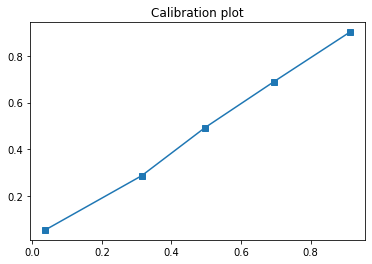

In [305]:
plt.plot(*calibration_curve(valid.y, smpred), 's-')
plt.title('Calibration plot')
plt.show()

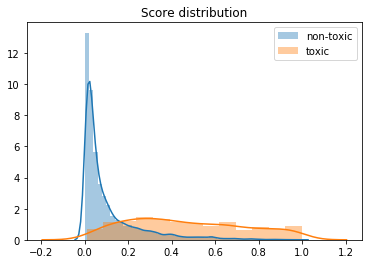

In [299]:
fig, ax = plt.subplots()

sns.distplot(smpred[valid.y == 0], ax=ax, label='non-toxic')
sns.distplot(smpred[valid.y == 1], ax=ax, label='toxic')
plt.legend()
plt.title('Score distribution')
plt.show()

In [240]:
for lang in ['es', 'it', 'tr']:
    mask = valid.dataset['lang'] == lang
    acc = accuracy_score(valid.y[mask], np.round(pred[mask]))
    auc = roc_auc_score(valid.y[mask], pred[mask])
    print(f'{lang}: acc {acc:.4f}, auc {auc:.4f}')

es: acc 0.8696, auc 0.8733
it: acc 0.8528, auc 0.8532
tr: acc 0.9167, auc 0.9672


In [19]:
pred, loss, acc = trnr.test()

test: 100%|##########| 31906/31906 [38:58<00:00, 13.65it/s]


## Full model training

In [2]:
reload(dataset)
reload(transforms)

<module 'transforms' from '../src/transforms.py'>

In [2]:
backbone_name = 'xlm-roberta-large'

Datasets

In [3]:
max_length = 256

valid = dataset.TokenizerDataset('../input/jigsaw_miltilingual_valid_translated.csv', max_length=max_length,
                                 tokenizer_name=backbone_name, text_column='comment_text')
test = dataset.TokenizerDataset('../input/jigsaw_miltilingual_test_translated.csv',  max_length=max_length,
                                tokenizer_name=backbone_name, text_column='content')

train_transforms = [transforms.ShuffleSentences(p=0.2),
                    transforms.SwapWords(p=0.5, swap_p=0.1),
                    transforms.DropWords(p=0.5, drop_p=0.05),
                    ]

train = dataset.TokenizerDataset('../input/jigsaw-toxic-comment-train.csv', max_length=max_length,
                                 tokenizer_name=backbone_name, transforms=train_transforms)
train_ub = dataset.TokenizerDataset('../input/jigsaw-unintended-bias-train.csv', max_length=max_length, 
                                    tokenizer_name=backbone_name, transforms=train_transforms)
train = dataset.ConcatDataset([train, train_ub])

In [4]:
batch_size = 3
batch_size_val = 8
num_workers = 8

loader_train = D.DataLoader(train, 
                            sampler=train.weighted_sampler(), 
                            batch_size=batch_size, num_workers=num_workers)
loader_valid = D.DataLoader(valid, 
                            batch_size=batch_size_val, num_workers=num_workers)
loader_test = D.DataLoader(test, 
                           batch_size=batch_size_val, num_workers=num_workers)

len(loader_train), len(loader_valid), len(loader_test)

(89074, 1000, 7977)

In [5]:
reload(models)

<module 'models' from '../src/models.py'>

In [6]:
head = models.SimplePoolingHead(in_features=3072, mix=mix.Mixup(), dropout=0.5)

In [7]:
backbone = XLMRobertaModel.from_pretrained(backbone_name, output_hidden_states=False, num_labels=1)

In [8]:
# Load pretrained head
head_cp = '../checkpoints/simple.pth'
head.load_state_dict(torch.load(head_cp, map_location='cpu')['model'])

<All keys matched successfully>

In [8]:
model = models.Model(backbone=backbone, head=head)

In [9]:
reload(trainer)

<module 'trainer' from '../src/trainer.py'>

In [10]:
optimizer = AdamW(model.parameters(), lr=1e-6)

trnr = trainer.Trainer('roberta_simple_head_ub', model, 
                       loader_train, loader_valid, loader_test,
                       epochs=10,
                       monitor='val_loss',
                       optimizer=optimizer,
                       gradient_accumulation=16,
#                        opt_level='O1',
                      )

In [11]:
trnr.load_checkpoint('../checkpoints/roberta_simple_head.pth', ignore=['scheduler'])

Loaded model from ../checkpoints/roberta_simple_head.pth
epoch 1, loss: 0.0328 val_loss: 0.2469 val_acc: 0.8912 val_auc: 0.9279 


In [12]:
for param_group in trnr.optimizer.param_groups:
    param_group['lr'] = 1e-6

In [ ]:
trnr.fit()

ep. 0000 (lr 1.00e-06):   2%|2         | 1872/89074 [10:47<8:27:45,  2.86it/s, loss=0.386, acc=0.828] 

Validate

In [25]:
trnr.meters['val_auc'].history

[0.9259574161472782, 0.9279267692233791, 0.929378054784979]

In [ ]:
trnr.load_checkpoint()

In [67]:
reload(dataset)

<module 'dataset' from '../src/dataset.py'>

In [68]:
valid = dataset.TokenizerDataset('../input/jigsaw_miltilingual_valid_translated.csv', 
                                 tokenizer_name=backbone_name, text_column='translated')
loader_valid = D.DataLoader(valid, batch_size=8, num_workers=num_workers)

In [49]:
trnr.loader_valid = loader_valid

In [50]:
pred, loss, acc, auc = trnr.validate()

valid: 100%|##########| 1000/1000 [04:27<00:00,  3.73it/s]


In [28]:
smpred = softmax(pred / 1, 1)[:,1]
smpred[:5]

array([0.25817168, 0.04423533, 0.4333852 , 0.02166644, 0.05889589],
      dtype=float32)

In [51]:
smpred_translated = softmax(pred / 1, 1)[:,1]
smpred_translated[:5]

array([0.22302572, 0.02749701, 0.4935527 , 0.03099989, 0.13124225],
      dtype=float32)

In [79]:
def prediction_analysis(smpred):
    acc = accuracy_score(valid.y, np.round(smpred))
    auc = roc_auc_score(valid.y, smpred)
    print(f'    acc {acc:.4f}, auc {auc:.4f}\n')

    for lang in ['es', 'it', 'tr']:
        mask = valid.dataset['lang'] == lang
        acc = accuracy_score(valid.y[mask], np.round(smpred[mask]))
        auc = roc_auc_score(valid.y[mask], smpred[mask])
        print(f'{lang}: acc {acc:.4f}, auc {auc:.4f}')
        
    fig, ax = plt.subplots(ncols=2, figsize=(7,3))
    
    ax[0].set_title('Score distribution')
    sns.distplot(smpred[valid.y == 0], ax=ax[0], label='non-toxic')
    sns.distplot(smpred[valid.y == 1], ax=ax[0], label='toxic')
    ax[0].legend()
    
    ax[1].set_title('Calibration plot')
    ax[1].plot(*calibration_curve(valid.dataset['toxic'], smpred), 's-')
    plt.show()

    acc 0.8912, auc 0.9279

es: acc 0.8788, auc 0.9213
it: acc 0.8640, auc 0.9071
tr: acc 0.9243, auc 0.9837


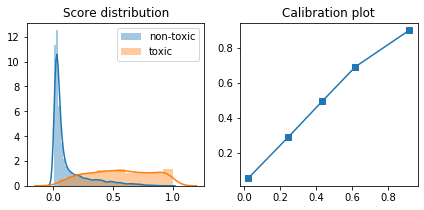

In [80]:
prediction_analysis(smpred)

    acc 0.8816, auc 0.9255

es: acc 0.8392, auc 0.9026
it: acc 0.8344, auc 0.8849
tr: acc 0.9563, auc 0.9820


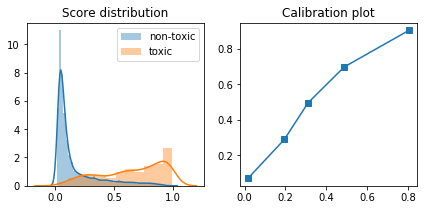

In [81]:
prediction_analysis(smpred_translated)

    acc 0.8929, auc 0.9346

es: acc 0.8664, auc 0.9194
it: acc 0.8616, auc 0.9069
tr: acc 0.9410, auc 0.9869


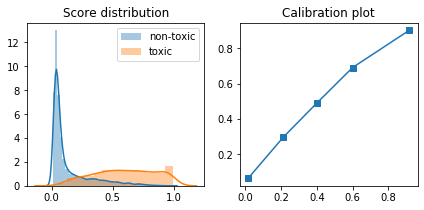

In [82]:
alpha = 0.6
prediction_analysis(smpred_translated * (1-alpha) + smpred * alpha )